## 0. Import Library

In [72]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## 1. Load Data

In [41]:
# 경로 설정
data_dir = "./newdataset"

# 이미지 유형 리스트
file_types = ['train', 'val', 'test']
image_types = ['coronal', 'sagittal', 'transverse', 'transverse_stripped', 'transverse_masked']


In [42]:
# 각 파일을 읽어오는 딕셔너리 생성, train, test, validation
coronal = {}
sagittal = {}
transverse = {}
transverse_stripped = {}
transverse_masked = {}
labels = {}

# 파일 읽어 딕셔너리에 저장
for file_type in file_types:
    coronal[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_coronal.npy")
    sagittal[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_sagittal.npy")
    transverse[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_transverse.npy")
    transverse_stripped[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_transverse_stripped.npy")
    transverse_masked[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_transverse_masked.npy")

# 라벨 저장
for file_type in file_types:
    labels[f"{file_type}"] = np.load(f"{data_dir}/{file_type}_labels.npy")
      
# 데이터 출력 
print("coronal train Shape:", coronal["train"].shape)
print("sagittal train Shape:", sagittal["train"].shape)
print("transverse train Shape:", transverse["train"].shape)
print("transverse_stripped train Shape:", transverse_stripped["train"].shape)
print("transverse_masked train Shape:", transverse_masked["train"].shape)

for file_type in file_types:
    print(f"{file_type}_label Shape: ", labels[f"{file_type}"].shape)


coronal train Shape: (120, 224, 224, 1)
sagittal train Shape: (120, 224, 224, 1)
transverse train Shape: (120, 224, 224, 1)
transverse_stripped train Shape: (120, 224, 224, 1)
transverse_masked train Shape: (120, 224, 224, 1)
train_label Shape:  (120,)
val_label Shape:  (40,)
test_label Shape:  (40,)


## 2. Modeling

In [43]:
# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,              # 회전 
    width_shift_range=0.1,          # 수평 이동 
    height_shift_range=0.1,         # 수직 이동 
    shear_range=0.1,                # 전단 변환
    zoom_range=0.1,                 # 확대/축소
    horizontal_flip=True,           # 수평 반전
    brightness_range=[0.9, 1.1]    # 밝기 조정
)

In [44]:
# 모델 생성 및 컴파일 함수
def create_compile_model(input_shape):
    model = models.Sequential()
    
  # 첫 번째 합성곱층
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.))
    
    # 두 번째 합성곱층
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # 세 번째 합성곱층
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # 평탄화
    model.add(layers.Flatten())
    
    # 완전 연결층
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # 이진 분류를 위한 출력층

    # 컴파일
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [93]:
def create_and_fit_model(train_data, train_labels, val_data, val_labels):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # 모델 생성 및 컴파일
    model = create_compile_model((224, 224, 1))
    
    # 학습
    history = model.fit(
        train_data, train_labels,
        epochs=100,
        batch_size=32,
        validation_data=(val_data, val_labels),
        callbacks=[reduce_lr]
    )
    return history


### 2-0. augmentation 적용 버전

In [90]:
# coronal 이미지 유형에 맞는 데이터 불러오기
train_data = coronal["train"]
val_data = coronal["val"]
train_labels = labels["train"]
val_labels = labels["val"]

# 레이블을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 모델 생성 및 컴파일
model = create_compile_model((224, 224, 1))

# 콜백함수
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 학습
history = model.fit(
    datagen.flow(train_data, train_labels), # augmentation 적용
    batch_size= 32,
    epochs=100,
    validation_data=(val_data, val_labels),
    callbacks=[reduce_lr]
)

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/chaewon/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 796ms/step - accuracy: 0.5295 - loss: 3.8789 - val_accuracy: 0.4750 - val_loss: 2.1918 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step - accuracy: 0.5221 - loss: 2.0242 - val_accuracy: 0.5000 - val_loss: 1.6997 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 795ms/step - accuracy: 0.4901 - loss: 1.6907 - val_accuracy: 0.5000 - val_loss: 1.6564 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - accuracy: 0.5425 - loss: 1.6227 - val_accuracy: 0.5000 - val_loss: 1.4789 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - accuracy: 0.5167 - loss: 1.4271 - val_accuracy: 0.5000 - val_loss: 1.2477 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - accuracy: 0.4798 - loss: 1.2059 - val_accuracy: 0.5000 - val_loss: 1.1007 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step - accuracy: 0.5042 - loss: 1.0822 - val_acc

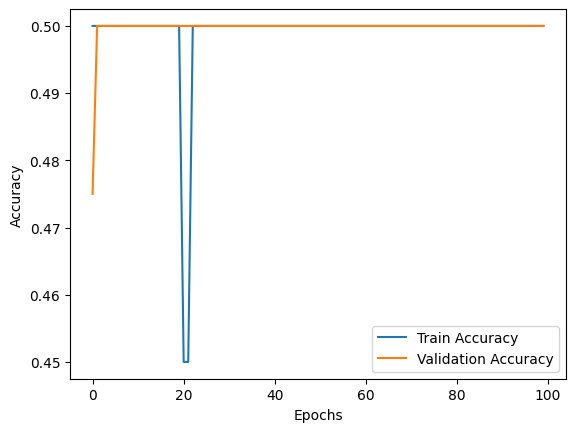

In [94]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2-1. Coronal section

In [95]:
# 이미지 유형에 맞는 데이터 불러오기
train_data = coronal["train"]
val_data = coronal["val"]
train_labels = labels["train"]
val_labels = labels["val"]

# 레이블을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 불러온 데이터를 모델 학습에 사용
history = create_and_fit_model(train_data, train_labels, val_data, val_labels)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 850ms/step - accuracy: 0.4254 - loss: 31.3807 - val_accuracy: 0.5750 - val_loss: 4.8321 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step - accuracy: 0.5579 - loss: 25.1450 - val_accuracy: 0.3250 - val_loss: 5.4372 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step - accuracy: 0.5798 - loss: 14.5354 - val_accuracy: 0.5000 - val_loss: 6.8172 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 837ms/step - accuracy: 0.7267 - loss: 6.7705 - val_accuracy: 0.4750 - val_loss: 10.0342 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 890ms/step - accuracy: 0.6888 - loss: 6.0766 - val_accuracy: 0.5000 - val_loss: 15.1263 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 830ms/step - accuracy: 0.5831 - loss: 5.9107 - val_accuracy: 0.5000 - val_loss: 20.6913 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step - accuracy: 0.7071 - loss: 5.6841 - v

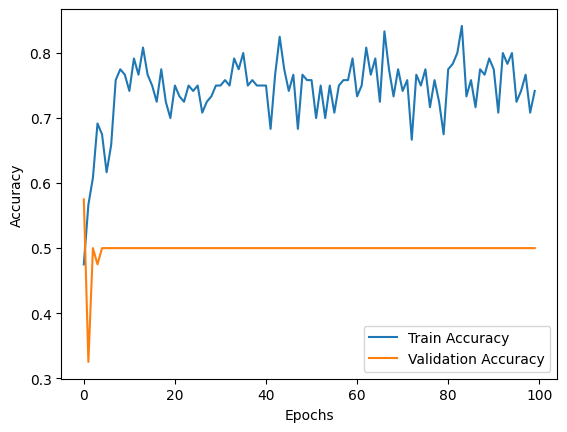

In [96]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2-2. Sagittal section

In [97]:
# 이미지 유형에 맞는 데이터 불러오기
train_data = sagittal["train"]
val_data = sagittal["val"]
train_labels = labels["train"]
val_labels = labels["val"]

# 레이블을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 불러온 데이터를 모델 학습에 사용
history = create_and_fit_model(train_data, train_labels, val_data, val_labels)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 847ms/step - accuracy: 0.5223 - loss: 35.6130 - val_accuracy: 0.5250 - val_loss: 4.8576 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 743ms/step - accuracy: 0.5510 - loss: 26.3490 - val_accuracy: 0.5000 - val_loss: 5.5115 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - accuracy: 0.5060 - loss: 12.4365 - val_accuracy: 0.4000 - val_loss: 5.8734 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step - accuracy: 0.6123 - loss: 9.3072 - val_accuracy: 0.4750 - val_loss: 6.8383 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step - accuracy: 0.6304 - loss: 6.4729 - val_accuracy: 0.5000 - val_loss: 8.5396 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - accuracy: 0.6425 - loss: 5.8426 - val_accuracy: 0.5000 - val_loss: 10.4027 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - accuracy: 0.6171 - loss: 5.8555 - val

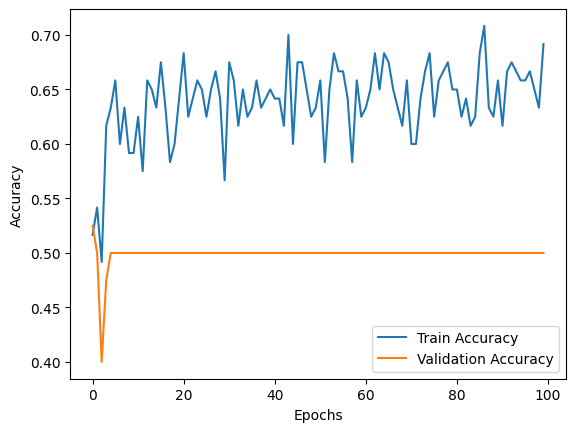

In [98]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2-3. Transverse section

#### (1) without skull stripping

In [99]:
# 이미지 유형에 맞는 데이터 불러오기
train_data = transverse["train"]
val_data = transverse["val"]
train_labels = labels["train"]
val_labels = labels["val"]

# 레이블을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 불러온 데이터를 모델 학습에 사용
history = create_and_fit_model(train_data, train_labels, val_data, val_labels)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - accuracy: 0.4815 - loss: 30.3356 - val_accuracy: 0.5250 - val_loss: 4.9442 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - accuracy: 0.5681 - loss: 18.1187 - val_accuracy: 0.5000 - val_loss: 6.3451 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step - accuracy: 0.5588 - loss: 12.2956 - val_accuracy: 0.5000 - val_loss: 8.1569 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step - accuracy: 0.5592 - loss: 9.5149 - val_accuracy: 0.5000 - val_loss: 11.0047 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step - accuracy: 0.5373 - loss: 6.9160 - val_accuracy: 0.5000 - val_loss: 13.1747 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - accuracy: 0.6902 - loss: 5.8717 - val_accuracy: 0.5000 - val_loss: 13.6470 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step - accuracy: 0.6394 - loss: 6.9545 - v

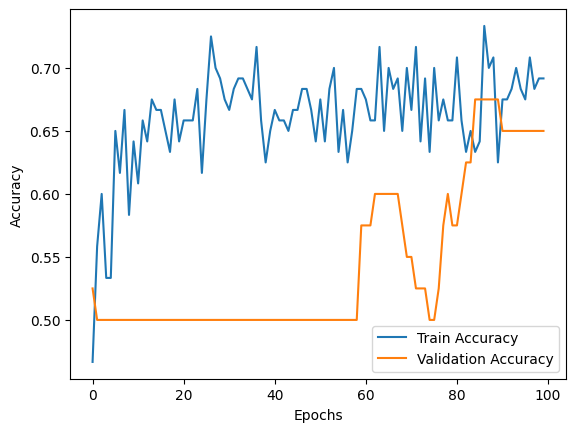

In [100]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### (2) with skull stripping

In [101]:
# 이미지 유형에 맞는 데이터 불러오기
train_data = transverse_stripped["train"]
val_data = transverse_stripped["val"]
train_labels = labels["train"]
val_labels = labels["val"]

# 레이블을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 불러온 데이터를 모델 학습에 사용
history = create_and_fit_model(train_data, train_labels, val_data, val_labels)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 857ms/step - accuracy: 0.5852 - loss: 21.9793 - val_accuracy: 0.5750 - val_loss: 4.8415 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - accuracy: 0.5612 - loss: 14.2618 - val_accuracy: 0.5500 - val_loss: 5.2191 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.6979 - loss: 10.3985 - val_accuracy: 0.5250 - val_loss: 5.5512 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step - accuracy: 0.6915 - loss: 7.4153 - val_accuracy: 0.4750 - val_loss: 6.2379 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - accuracy: 0.6060 - loss: 6.6711 - val_accuracy: 0.5000 - val_loss: 6.9055 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step - accuracy: 0.5165 - loss: 6.0723 - val_accuracy: 0.5000 - val_loss: 7.5105 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step - accuracy: 0.6215 - loss: 5.7937 - val_

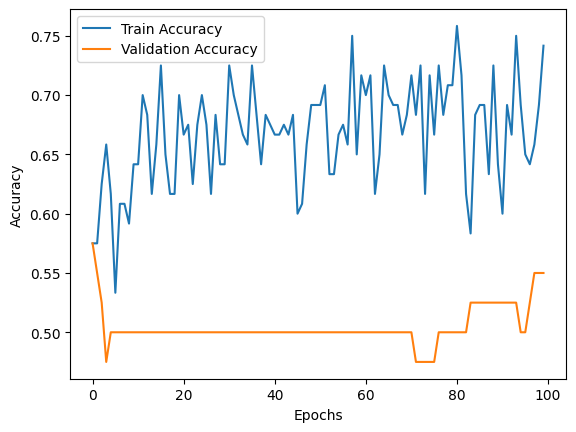

In [102]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### (3) with masked data

In [103]:
# 이미지 유형에 맞는 데이터 불러오기
train_data = transverse_masked["train"]
val_data = transverse_masked["val"]
train_labels = labels["train"]
val_labels = labels["val"]

# 레이블을 numpy 배열로 변환
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# 불러온 데이터를 모델 학습에 사용
history = create_and_fit_model(train_data, train_labels, val_data, val_labels)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 739ms/step - accuracy: 0.5296 - loss: 27.3283 - val_accuracy: 0.5250 - val_loss: 4.7557 - learning_rate: 0.0010
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step - accuracy: 0.5221 - loss: 19.1700 - val_accuracy: 0.4750 - val_loss: 5.0692 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - accuracy: 0.5888 - loss: 12.9799 - val_accuracy: 0.5000 - val_loss: 6.1023 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.5975 - loss: 9.4920 - val_accuracy: 0.5000 - val_loss: 6.5246 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - accuracy: 0.6785 - loss: 6.8850 - val_accuracy: 0.6250 - val_loss: 6.3798 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step - accuracy: 0.6581 - loss: 5.7137 - val_accuracy: 0.5250 - val_loss: 6.2082 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 0.6244 - loss: 5.7305 - val_

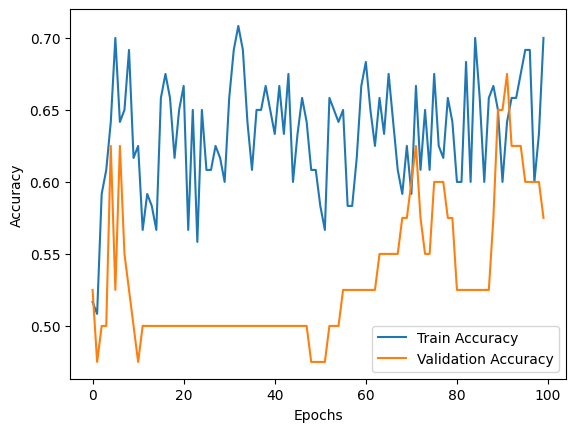

In [104]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()